Data preparation

In [1]:
import csv
import cv2  
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
import random

def unifyPaths(IMGpath, path, isCustom):
    splitChar = '\\' if isCustom else '/'

    imgName = IMGpath.split(splitChar)[-1]
    return path + 'IMG/' + imgName

def importInputData(pathToCollectedData, isCustom):
    
    dropRate = 0.5
    correction = 0.2
    sampleList = []

    with open(pathToCollectedData + 'driving_log.csv') as csvfile:
        fieldnames = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'] if  isCustom else None
        reader = csv.DictReader(csvfile, fieldnames = fieldnames)
        for line in reader:
            # line['center'] =  (unifyPaths(line['center'], pathToCollectedData, isCustom))
            # line['left'] =  (unifyPaths(line['left'], pathToCollectedData, isCustom))
            # line['right'] =  (unifyPaths(line['right'], pathToCollectedData, isCustom))
            # line['steering'] = float(line['steering'])
            # del line['throttle']
            # del line['brake']
            # del line['speed']
            # sampleList.append(line)

            # if float(line['steering']) == 0.0 and random.random() < dropRate:
            #     pass
            # else:

            sample = {}
            sample['image'] = (unifyPaths(line['center'], pathToCollectedData, isCustom))
            sample['steering']  = float(line['steering'])
            sampleList.append(sample)

            if float(line['steering']) == 0.0 and random.random() < dropRate:
                pass
            else:
                sample = {}
                sample['image'] = (unifyPaths(line['left'], pathToCollectedData, isCustom))
                sample['steering']  = float(line['steering']) + correction
                sampleList.append(sample)

                sample = {}
                sample['image'] = (unifyPaths(line['right'], pathToCollectedData, isCustom))
                sample['steering']  = float(line['steering']) - correction
                sampleList.append(sample)


    return sampleList


def trimZeroSteeringSamples(samples):
    trimmedSamples =[]
    for sample in samples:
        if sample['steering'] == 0.0 and random.random() < 0.5:
            pass
        else:
            trimmedSamples.append(sample)
    return trimmedSamples

In [18]:
sampleList = importInputData('./SampleData/', isCustom = False)
DownloadedData = importInputData('./DownloadedData/', isCustom = True)
CuratedData = importInputData('./CuratedData/', isCustom = True)

dataSet =  sampleList #+ CuratedData

print('Number of unique images ' + str(len(dataSet)))
# dataSetTrimmed = trimZeroSteeringSamples(dataSet)
# print('Number of unique trimmed images ' + str(len(dataSetTrimmed)))

train_samples, validation_samples = train_test_split(dataSet, test_size=0.35)


Number of unique images 8036


Print histograms

In [4]:
def plotHistogram(data):

    labels = []
    for item in data:
        labels.append(item['steering'])
    #print (labels)
    bins = np.arange(start = -1.0, stop = 1.05, step = 0.05)
    bins = np.concatenate([bins[:20], [-0.001,0.001], bins[21:]])

    hist_vals, _ ,_ = plt.hist(labels, bins = bins)
    plt.show()

    max_hist_val = hist_vals.max()
    max_hist_idx = hist_vals.argmax()


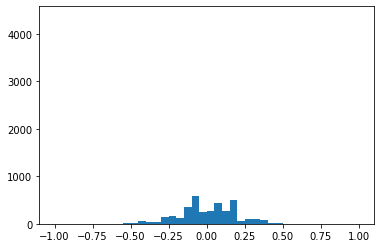

In [19]:
plotHistogram(dataSet)

In [11]:
from random import shuffle

def generator(samples, batch_size=32):
    batch_size = int (batch_size / 2)
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(batch_sample['image'])
                center_angle = batch_sample['steering']

                images.append(center_image)
                angles.append(center_angle)

                images.append(cv2.flip(center_image, 0))
                angles.append(-center_angle)


            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield tuple(sklearn.utils.shuffle(X_train, y_train))





In [20]:
batch_size=64

train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

extraData = 1

augmentedTrainSetLen = len(train_samples) * (1 + extraData)
augementedValidSetLen = len(validation_samples) * (1 + extraData)

print('Training set ' + str(augmentedTrainSetLen))
print('Validation set ' + str(augementedValidSetLen))

Training set 10446
Validation set 5626


Model Creation 

In [8]:
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [9]:
def converter(x):

    #x has shape (batch, width, height, channels)
    return (0.21 * x[:,:,:,:1]) + (0.72 * x[:,:,:,1:2]) + (0.07 * x[:,:,:,-1:])
def RGB2HSV(x):
    return tf.image.rgb_to_hsv(x)

def RGB2YUV(x):
    return tf.image.rgb_to_yuv(x)

def NvidiaBasedModel():
    activation = 'elu'
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)),input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, name = 'Normalisation'))
    # model.add(Lambda(RGB2YUV))
    

    # model.add(Dropout(0.3))
    model.add(Conv2D(24,kernel_size = (5,5), strides=(2,2),activation = activation))
    # model.add(Dropout(0.3))
    model.add(Conv2D(36,5,2,activation = activation))
    # model.add(Dropout(0.3))
    model.add(Conv2D(48,5,2,activation = activation))
    # model.add(Dropout(0.3))
    model.add(Conv2D(64,3,activation = activation))
    # model.add(Dropout(0.3))
    model.add(Conv2D(64,3,activation = activation))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100))  
    # model.add(Dropout(0.3))     
    model.add(Dense(50))
    # model.add(Dropout(0.3))
    model.add(Dense(10))
    # model.add(Dropout(0.3))
    model.add(Dense(1))
    return model



In [23]:
 model = NvidiaBasedModel()
 model.compile(loss='mse', optimizer='adam')
 callback = []
#  callback = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.001)

 history_object = model.fit(train_generator, 
            steps_per_epoch=np.ceil(augmentedTrainSetLen / batch_size), 
            validation_data=validation_generator, 
            validation_steps=np.ceil(augementedValidSetLen / batch_size), 
            epochs=7, callbacks=[callback], verbose=1)

Epoch 1/7
164/164 [==============================] - 13s 77ms/step - loss: 0.5363 - val_loss: 0.0140
Epoch 2/7
164/164 [==============================] - 13s 81ms/step - loss: 0.0135 - val_loss: 0.0125
Epoch 3/7
164/164 [==============================] - 13s 82ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 4/7
164/164 [==============================] - 13s 81ms/step - loss: 0.0090 - val_loss: 0.0125
Epoch 5/7
164/164 [==============================] - 14s 87ms/step - loss: 0.0090 - val_loss: 0.0119
Epoch 6/7
164/164 [==============================] - 14s 86ms/step - loss: 0.0083 - val_loss: 0.0125
Epoch 7/7
164/164 [==============================] - 14s 85ms/step - loss: 0.0078 - val_loss: 0.0117


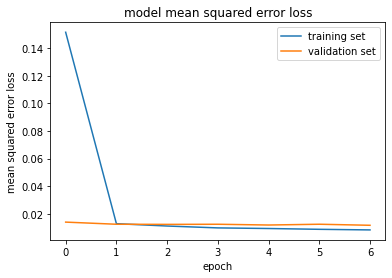

In [24]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [25]:
model.save('model_new2.h5')

In [26]:
pathToTestData = './TestData/Curve1/'

images = []
angles = []
with open(pathToTestData + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:      
        center_image_path = pathToTestData + 'IMG/'+line[0].split('\\')[-1]
        center_image = cv2.imread(center_image_path)
        center_angle = float(line[3])


        images.append(center_image)
        angles.append(center_angle)

    X_test = np.array(images)
    y_test = np.array(angles)
            
    model.evaluate(X_test, y_test)

    

    

9/9 [==============================] - 0s 25ms/step - loss: 0.0093


In [27]:
pathToTestData = './TestData/Curve2/'

images = []
angles = []
with open(pathToTestData + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:      
        center_image_path = pathToTestData + 'IMG/'+line[0].split('\\')[-1]
        center_image = cv2.imread(center_image_path)
        center_angle = float(line[3])


        images.append(center_image)
        angles.append(center_angle)

    X_test = np.array(images)
    y_test = np.array(angles)
            
    model.evaluate(X_test, y_test)


10/10 [==============================] - 0s 20ms/step - loss: 0.0175


In [ ]:
model = NvidiaBasedModel()
model.compile(loss='mse', optimizer='adam')
print(model.summary())

# model.get_layer('conv2d_25').output
